<a href="https://colab.research.google.com/github/MartaCampagnoli/HateSpeechDetection/blob/main/Output%20Notebooks/Classification_Part2_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import gensim
import tensorflow as tf
import io
import gensim.downloader
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from google.colab import files
from tensorflow import keras
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models, layers, callbacks, regularizers
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, zero_one_loss, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

!pip install wget

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stemmer = nltk.SnowballStemmer("english")

In [ ]:
#modify stopwords list and preprocess data
stopwords = nltk.corpus.stopwords.words('english')
exceptions = ["no", "not" , "don't", "they", "them"]
stop_words = [word for word in stopwords if word not in exceptions]

def preprocess(text):
    text = ''.join([word for word in text])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(w) for w in tokens]
    return ' '.join(tokens)

In [ ]:
def encode_df(dataframe): #label encoder
    le = LabelEncoder()
    for column in dataframe.columns:
        dataframe['label'] = le.fit_transform(dataframe['label'])
    return dataframe

In [ ]:
#Training plots
legend_size = 14

def performance_plot(history):
    plt.figure(figsize=(20,8))

    #Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)
    plt.grid()

    #Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.ylabel('accuracy', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)
    plt.grid()

    plt.show()

earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10, restore_best_weights=True)
loss = keras.losses.BinaryCrossentropy()

In [ ]:
uploaded = files.upload() #cleandata.csv

Saving cleandata.csv to cleandata.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['cleandata.csv']))

In [ ]:
df = encode_df(df)

In [ ]:
train, test = train_test_split(df ,test_size=0.30, random_state = 42)

# Defining the network structures

In [ ]:
def evaluatemodel(model):
  model.evaluate(X_test300, y_test)
  y_predictions = model.predict(X_test300)
  y_predictions_np = tf.round(y_predictions).numpy()
  model_loss = zero_one_loss(y_test, y_predictions_np)
  return model_loss, y_predictions_np

In [ ]:
#cnn
def deepcnn(vocab_size, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
  model.add(Conv1D(64, 3, padding="same", activation='relu'))
  model.add(Conv1D(64, 3, padding="same", activation='relu'))
  model.add(Conv1D(64, 3, padding="same", activation='relu'))
  model.add(MaxPooling1D(3, padding='same'))
  model.add(Dropout(0.5))
  model.add(Conv1D(128, 3, padding="same", activation='relu'))
  model.add(Conv1D(128, 3, padding="same", activation='relu'))
  model.add(Conv1D(128, 3, padding="same", activation='relu'))
  model.add(MaxPooling1D(3, padding='same'))
  model.add(Dropout(0.4))
  model.add(Conv1D(64, 3, padding="same", activation='relu'))
  model.add(Conv1D(64, 3, padding="same", activation='relu'))
  model.add(Conv1D(64, 3, padding="same", activation='relu'))
  model.add(MaxPooling1D(3, padding='same'))
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
  return model

#bilstm

def bidlstm(vocab_size, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
  model.add(Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
  model.add(Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
  model.add(Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
  model.add(Dropout(0.4))
  model.add(Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
  model.add(Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
  model.add(Bidirectional(tf.keras.layers.LSTM(32)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
  return model

# Pretrained embeddings: CNN and Bidirectional

In [ ]:
#setting training and test
X_train, X_test, y_train, y_test = train['text'], test['text'], train['label'], test['label']
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

In [ ]:
#tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
max_length = 300
X_train300 = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test300 = pad_sequences(X_test, maxlen=max_length, padding='post')

In [ ]:
#function to try for pretrained models
def embedpretr(model, token):
  embedding_matrix = np.zeros((vocab_size, 300))
  for word, i in token.word_index.items():
    if word in model:
        embedding_matrix[i] = model[word]
  return embedding_matrix

In [ ]:
#Available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
w2vvectors = gensim.downloader.load('word2vec-google-news-300')
fast = gensim.downloader.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
embedding_matrix_pre = embedpretr(w2vvectors, tokenizer)

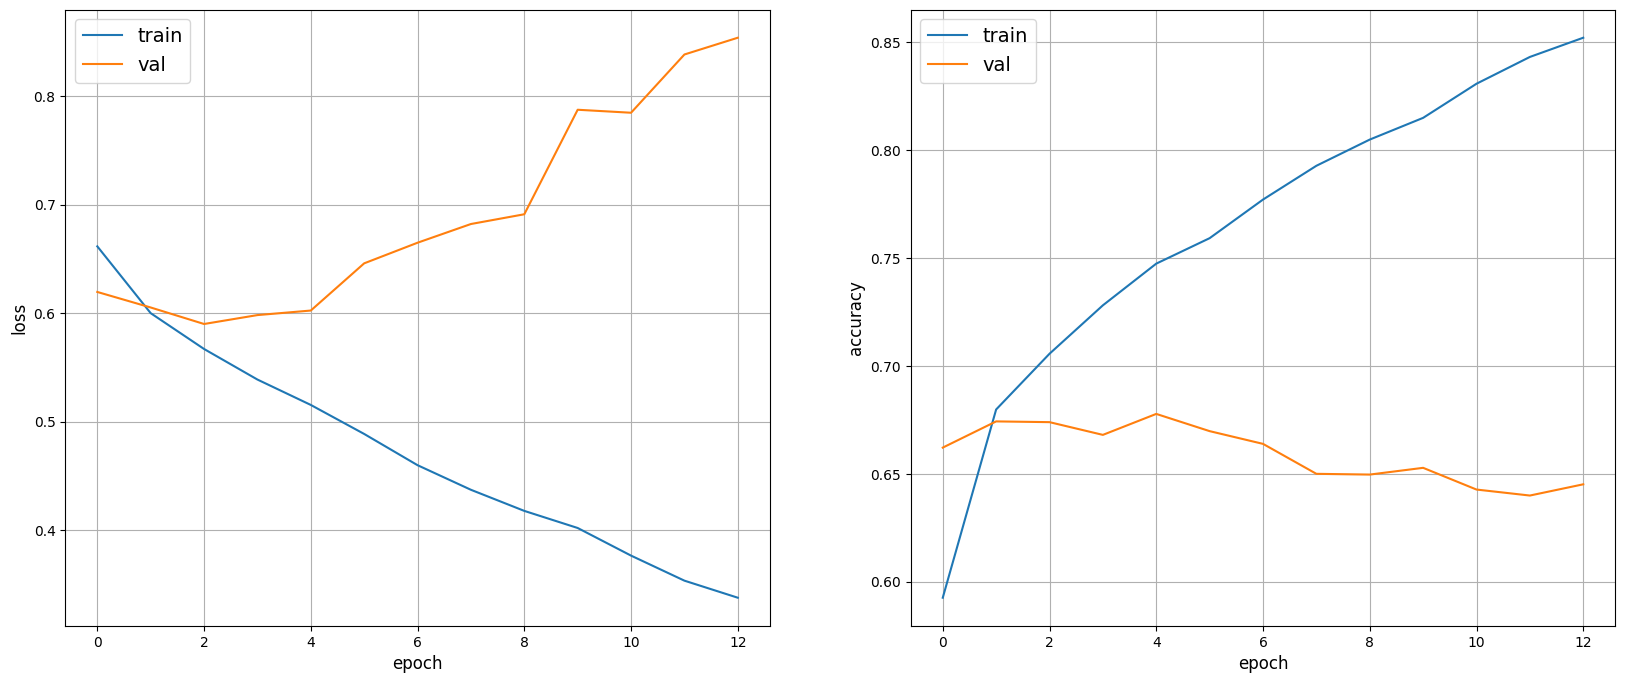

In [ ]:
#cnn with pretrained w2c
pretrainedcnnw = deepcnn(vocab_size, embedding_matrix_pre)
history = pretrainedcnnw.fit(X_train300, y_train, epochs=50, batch_size=128, verbose = 0, validation_split=0.1, callbacks=[earlystopping])
performance_plot(history)

In [ ]:
#evaluating the cnn
zeroloss, predictions = evaluatemodel(pretrainedcnnw)
print(f"Zero_one loss:", zeroloss)

386/386 [==============================] - 1s 3ms/step
Zero_one loss: 0.3225048606610499


              precision    recall  f1-score   support

           0       0.67      0.77      0.72      6633
           1       0.68      0.57      0.62      5711

    accuracy                           0.68     12344
   macro avg       0.68      0.67      0.67     12344
weighted avg       0.68      0.68      0.67     12344



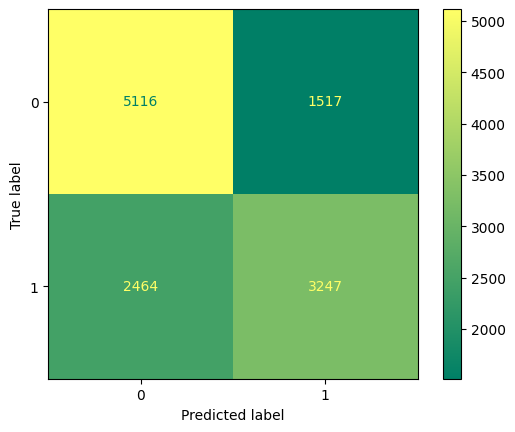

In [ ]:
print(metrics.classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap = 'summer')

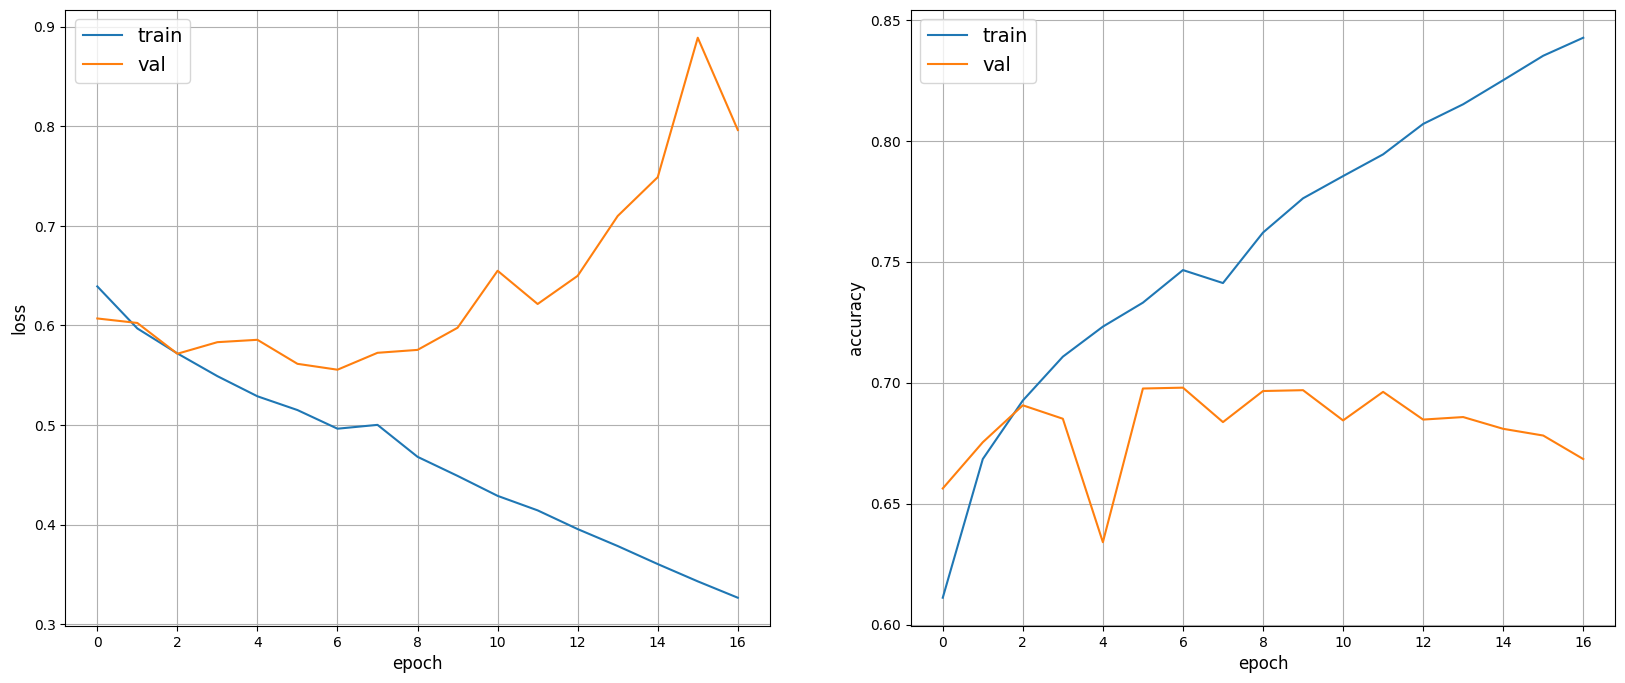

In [ ]:
pretrainedlstmw = bidlstm(vocab_size, embedding_matrix_pre)
history = pretrainedlstmw.fit(X_train300, y_train, epochs=50, batch_size=32, verbose = 0, validation_split=0.1, callbacks=[earlystopping])
performance_plot(history)

In [ ]:
zeroloss, predictions = evaluatemodel(pretrainedlstmw)
print(f"Zero_one loss:", zeroloss)

386/386 [==============================] - 24s 49ms/step
Zero_one loss: 0.30476344782890474


              precision    recall  f1-score   support

           0       0.70      0.75      0.72      6633
           1       0.68      0.64      0.66      5711

    accuracy                           0.70     12344
   macro avg       0.69      0.69      0.69     12344
weighted avg       0.69      0.70      0.69     12344



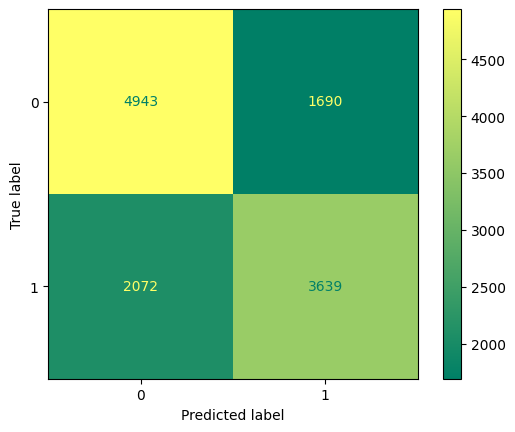

In [ ]:
print(metrics.classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap = 'summer')

In [ ]:
#fasttext

In [ ]:
embedding_matrix_pref = embedpretr(fast, tokenizer)

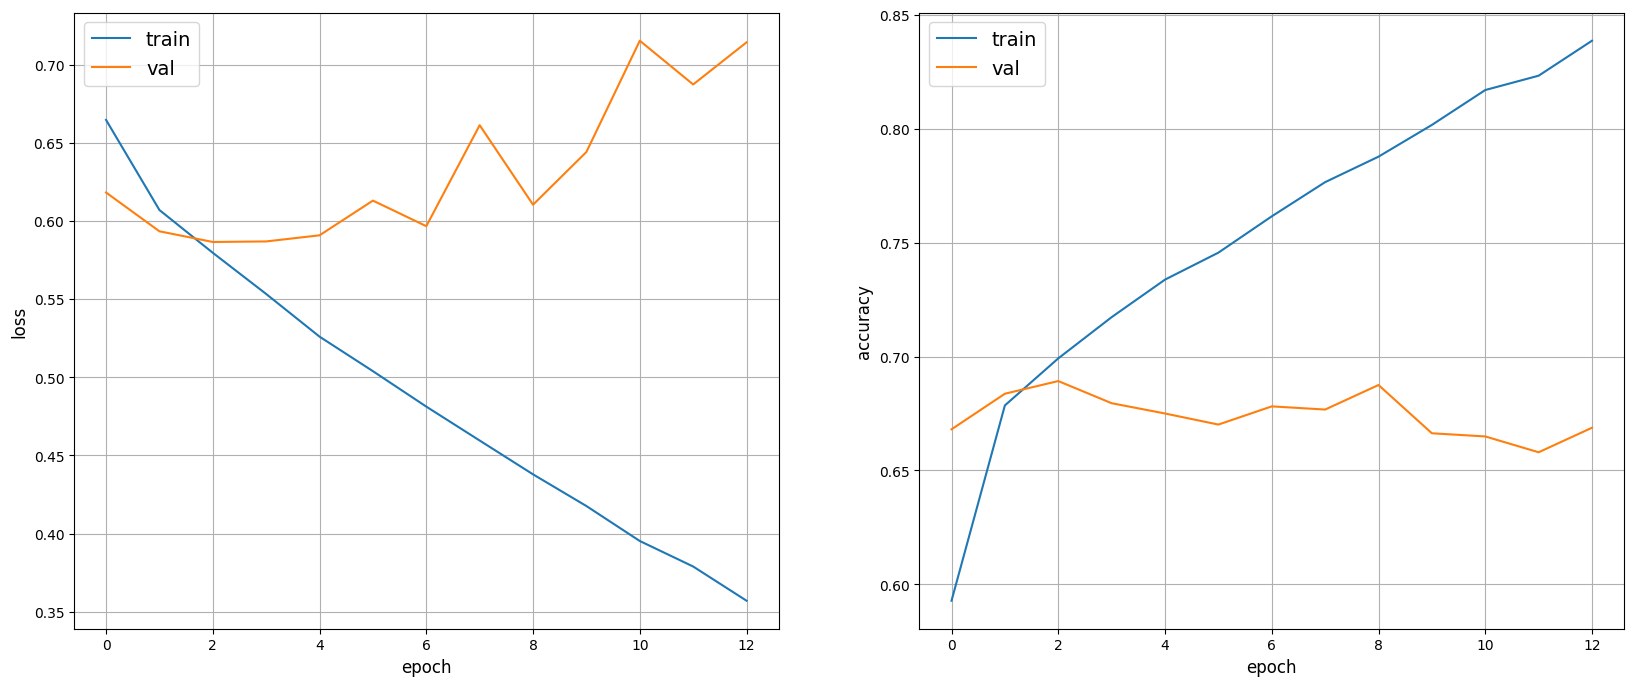

In [ ]:
pretrainedcnnf = deepcnn(vocab_size, embedding_matrix_pref)
history = pretrainedcnnf.fit(X_train300, y_train, epochs=50, batch_size=128, verbose = 0, validation_split=0.1, callbacks=[earlystopping])
performance_plot(history)

In [ ]:
zeroloss, predictions = evaluatemodel(pretrainedcnnf)
print(f"Zero_one loss:", zeroloss)

386/386 [==============================] - 1s 3ms/step
Zero_one loss: 0.3187783538561244


              precision    recall  f1-score   support

           0       0.68      0.77      0.72      6633
           1       0.68      0.58      0.63      5711

    accuracy                           0.68     12344
   macro avg       0.68      0.67      0.67     12344
weighted avg       0.68      0.68      0.68     12344



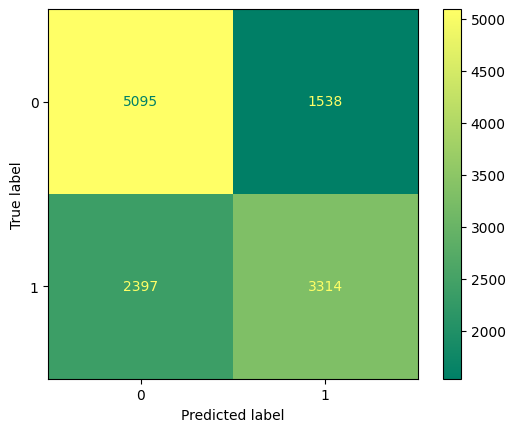

In [ ]:
print(metrics.classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap = 'summer')

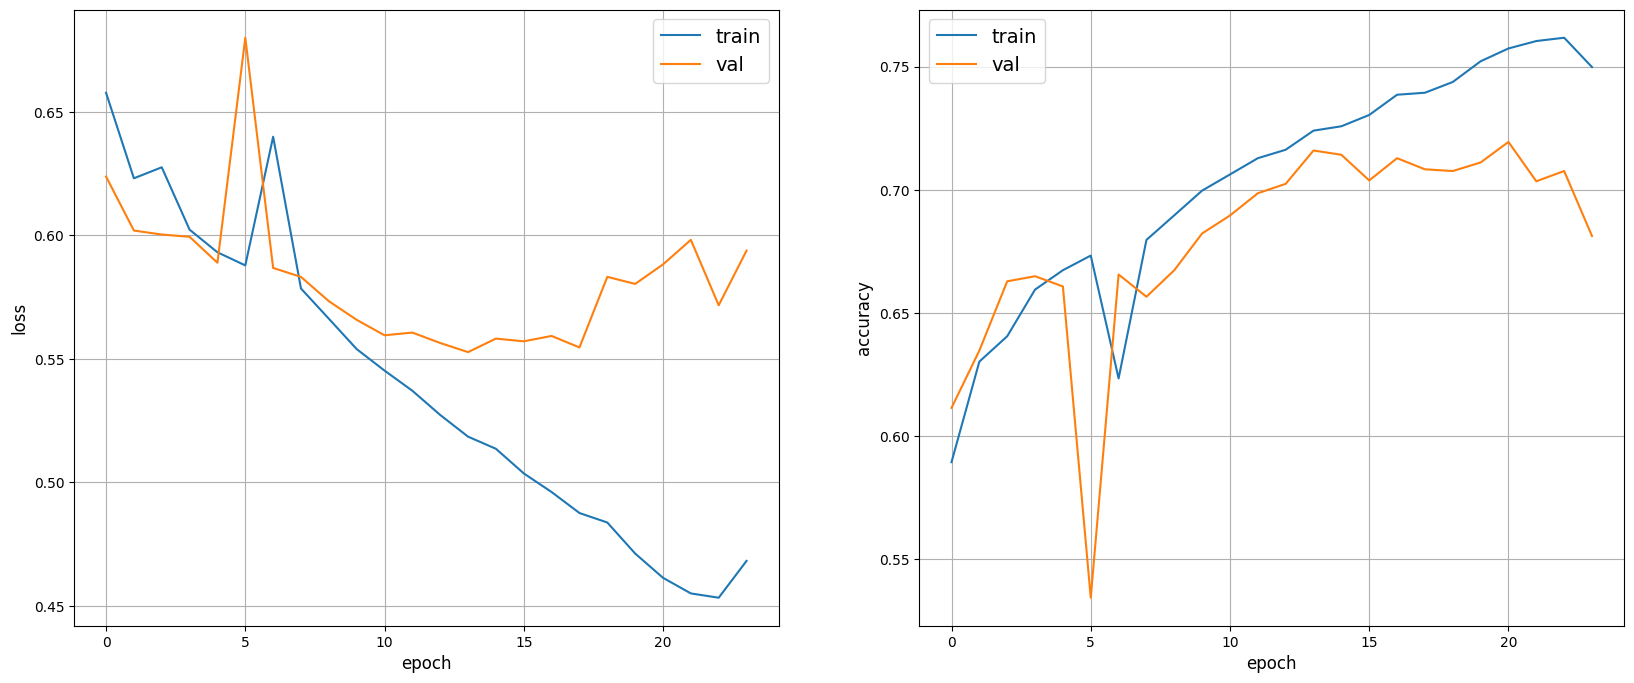

In [ ]:
pretrainedlstmf = bidlstm(vocab_size, embedding_matrix_pref)
history = pretrainedlstmf.fit(X_train300, y_train, epochs=50, batch_size=32, verbose = 0, validation_split=0.1, callbacks=[earlystopping])
performance_plot(history)

In [ ]:
zeroloss, predictions = evaluatemodel(pretrainedlstmf)
print(f"Zero_one loss:", zeroloss)

386/386 [==============================] - 24s 51ms/step
Zero_one loss: 0.30767984445884644


              precision    recall  f1-score   support

           0       0.69      0.77      0.73      6633
           1       0.69      0.61      0.65      5711

    accuracy                           0.69     12344
   macro avg       0.69      0.69      0.69     12344
weighted avg       0.69      0.69      0.69     12344



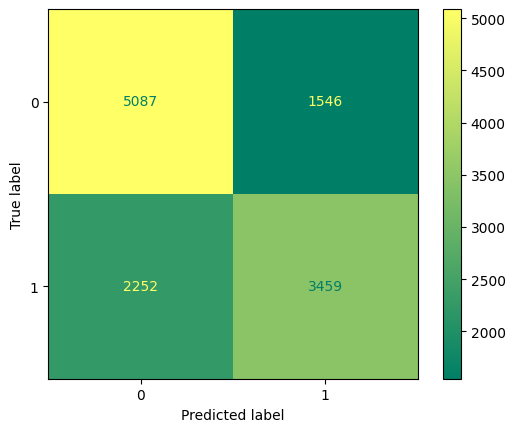

In [ ]:
print(metrics.classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap = 'summer')